In [1]:
import segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import nibabel as nib
import SimpleITK as sitk

## Run once for creating masks

In [2]:
segmentation.create_masks()

100%|██████████| 5/5 [00:00<00:00, 49.03it/s]


100%|██████████| 5/5 [00:00<00:00, 16.82it/s]


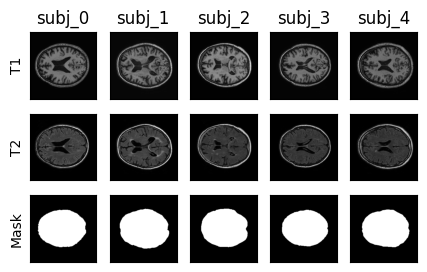

In [20]:
fig, ax = plt.subplots(3, 5, figsize=(5, 3))

layer = 25 
  
for i in tqdm(range(5)):
    t1 = nib.load(os.path.join('..','P2_Data',f'{i}','T1.nii')).get_fdata()
    t2 = nib.load(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii')).get_fdata()
    bm = nib.load(os.path.join('..','P2_Data',f'{i}','brainMask.nii')).get_fdata()
        
    titles = ['T1', 'T2', 'Mask']
    for k, img in enumerate([t1, t2, bm]):
            if k == 0:
                ax[k, i].set_title(f'subj_{i}')
            ax[k, i].set_xticks([])
            ax[k, i].set_yticks([])
            if i == 0:
                ax[k, i].set_ylabel(titles[k])
            ax[k, i].imshow(img[:, :, layer], cmap='gray')
            
plt.show()

In [2]:
t1_seg, t2_seg = [], []
for i in range(5):
    print(f'------------ Subject {i}---------------------')
    t1 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T1.nii'))
    t2 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii'))
    bm = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','brainMask.nii'))

    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm_array = sitk.GetArrayFromImage(bm)
    t1, t2 = segmentation.get_tissue(t1_array,t2_array,bm_array)
    
    
    
    t1_seg.append(t1)
    t2_seg.append(t2)
    

------------ Subject 0---------------------


 67%|██████▋   | 67/100 [00:14<00:06,  4.75it/s]


------------ Subject 1---------------------


 62%|██████▏   | 62/100 [00:14<00:08,  4.37it/s]


------------ Subject 2---------------------


 78%|███████▊  | 78/100 [00:17<00:04,  4.55it/s]


------------ Subject 3---------------------


 51%|█████     | 51/100 [00:10<00:10,  4.76it/s]


------------ Subject 4---------------------


 57%|█████▋    | 57/100 [00:12<00:09,  4.59it/s]


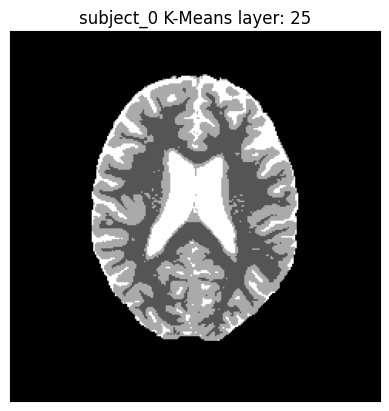

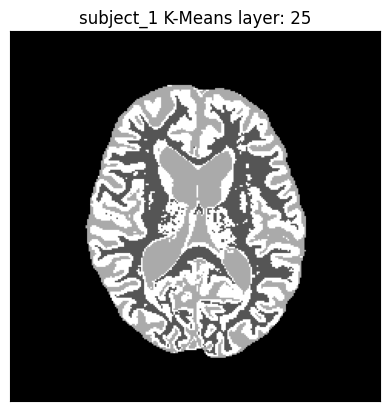

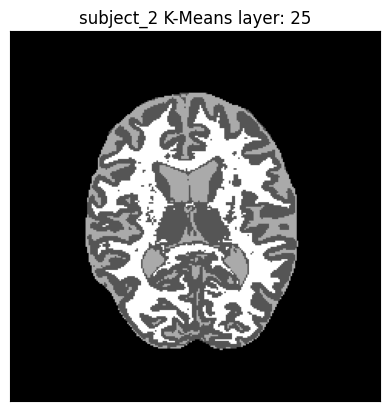

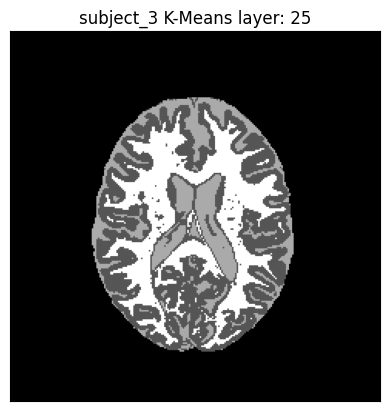

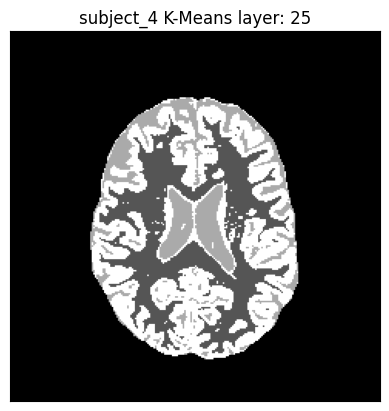

In [6]:
i = 0
layer = 25
for elements in t1_seg:
    plt.figure()
    plt.title(f'subject_{i} K-Means layer: {layer}')
    plt.imshow(elements[layer,:,:],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    i+=1